In [2]:
import re
import time
import pandas as pd
import json
import requests
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from bs4 import BeautifulSoup
from tqdm import tqdm
from datetime import datetime

In [3]:
#data 불러오기
stock = pd.read_csv('./recommend_stock.csv')

In [4]:
#date 타입 날짜 문자로 바꾸기
stock['end_date'] = stock.date.apply(lambda x : re.sub("-","",x))
stock['end_date']= stock['end_date'].astype('str')

#date date타입으로 변환
stock['date'] = pd.to_datetime(stock['date'])

In [5]:
stocks = stock

In [6]:
stocks

,date,stock_name,stock_code,end_date
0,2019-10-29,알리코제약,260660,20191029
1,2019-10-29,KPX생명과학,114450,20191029
2,2019-10-29,제일바이오,052670,20191029
3,2019-10-30,아스타,246720,20191030
4,2019-10-30,SM,063440,20191030
...,...,...,...,...
977,2023-02-01,오픈베이스,049480,20230201
978,2023-02-01,일성건설,013360,20230201
979,2023-02-02,선익시스템,171090,20230202
980,2023-02-02,누리플렉스,040160,20230202


In [7]:
#한국투자 API 보안 인증키 발급 
APP_KEY = "PSDbkNNrIX3j60cW2MEFnBGZDZ1BzpgDxvC0"
APP_SECRET = "QfaZRX24K15ojO4yjG5o5dM+SUvJT4PYiK+tKKzgikyhmfrnTXoxOwn9rCf2hzXdtOhh4v3/O4bSFfQgS+u6ojdb6KgWuyub4GRraoWYaJTJyHSRqWUPab2GiCvrI/aIjx5S925MohrETq0k/eopFHgMInG0lmZdAh5TaegaZ1NDpNvPW8Y="
URL_BASE = "https://openapi.koreainvestment.com:9443"
PATH = "oauth2/tokenP"
URL = f"{URL_BASE}/{PATH}"

headers = {"content-type":"application/json"}
body = {"grant_type":"client_credentials",
        "appkey":APP_KEY, 
        "appsecret":APP_SECRET}

res = requests.post(URL, headers=headers, data=json.dumps(body))
ACCESS_TOKEN = res.json()["access_token"]

In [8]:
#일자별 시세 가져오기 (함수)
def get_info_from_kisapi(stock_code,end_date):
    time.sleep(0.1)
    
    st_date = pd.date_range(end = end_date,periods=20)[0]
    st_date = st_date.strftime("%Y%m%d")
    
    URL = 'https://openapi.koreainvestment.com:9443/uapi/domestic-stock/v1/quotations/inquire-daily-itemchartprice'

    headers = {"Content-Type":"application/json", 
            "authorization": f"Bearer {ACCESS_TOKEN}",
            "appKey":APP_KEY,
            "appSecret":APP_SECRET,
            "tr_id":"FHKST03010100"
            }

    params = {
        "FID_COND_MRKT_DIV_CODE":"J",
        "FID_INPUT_ISCD":stock_code,
        "FID_INPUT_DATE_1" : st_date,
        "FID_INPUT_DATE_2" : end_date,
        "FID_PERIOD_DIV_CODE" : "D",
        "FID_ORG_ADJ_PRC" : "1"
    }

    res = requests.get(URL, headers=headers, params=params)   
    res = res.json().get('output2')[0:11]
    res.reverse()
    return res

In [369]:
#종목데이터 추출
temp = pd.DataFrame()
day = 10
for i in res:

    data = pd.DataFrame({
        'stck_oprc' :  i.get('stck_oprc'),
        'stck_clpr' : i.get('stck_clpr'),
        'stck_hgpr' : i.get('stck_hgpr'),
        'stck_lwpr' : i.get('stck_lwpr'),
        'acml_vol'  : i.get('acml_vol')},
        index=[f'D-{day}']
    )
    temp = pd.concat([temp,data])
    day -=1
temp= temp.transpose()

In [360]:
#세부데이터 추출 편집
#전일종가
br_pr = temp.iloc[1:2,9:10].reset_index(drop = True)
br_pr.columns = 'br_pr_'+ br_pr.columns
#당일시가
tr_pr = temp.iloc[2:3,10:].reset_index(drop = True)
tr_pr.columns = 'tr_pr_'+ tr_pr.columns
#거래량(10일)
br_vol = temp.iloc[4:5,0:10].reset_index(drop = True)
br_vol.columns = 'Volume_'+ br_vol.columns
#저점(10일)
br_lpr = temp.iloc[3:4,0:10].reset_index(drop = True)
br_lpr.columns = 'lpr_'+ br_lpr.columns
#데이터 합치기 
data = pd.concat([br_pr,tr_pr,br_vol,br_lpr], axis=1)
#인덱스 삽입
date_data = pd.DataFrame({'date' : end_date,
                          'stock_code' : stock_code}
                          ,index=[0])
data = pd.concat([date_data,data], axis =1 )


In [15]:
#종목 일자별 데이터 가져오기 (함수)
def get_info_from_stock(res):
    temp = pd.DataFrame()
    day = 10
    for i in res:

        data = pd.DataFrame({
            'stck_oprc' :  i.get('stck_oprc'),
            'stck_clpr' : i.get('stck_clpr'),
            'stck_hgpr' : i.get('stck_hgpr'),
            'stck_lwpr' : i.get('stck_lwpr'),
            'acml_vol'  : i.get('acml_vol')},
            index=[f'D{day}']
        )
        temp = pd.concat([temp,data])
        day -=1
    temp= temp.transpose()
    
    #전일종가
    br_pr = temp.iloc[1:2,9:10].reset_index(drop = True)
    br_pr.columns = 'br_pr_'+ br_pr.columns
    #당일시가
    tr_pr = temp.iloc[2:3,10:].reset_index(drop = True)
    tr_pr.columns = 'tr_pr_'+ tr_pr.columns
    #거래량(10일)
    br_vol = temp.iloc[4:5,0:10].reset_index(drop = True)
    br_vol.columns = 'Volume_'+ br_vol.columns
    #당일거래량
    tr_pr = temp.iloc[4:5,10:].reset_index(drop = True)
    tr_pr.columns = 'tr_vol_'+ tr_pr.columns
    #저점(10일)
    br_lpr = temp.iloc[3:4,0:10].reset_index(drop = True)
    br_lpr.columns = 'lpr_'+ br_lpr.columns
    #데이터 합치기 
    data = pd.concat([br_pr,tr_pr,br_vol,br_lpr], axis=1)
    #인덱스 삽입
    date_data = pd.DataFrame({'date' : end_date,
                            'stock_code' : stock_code}
                            ,index=[0])
    data = pd.concat([date_data,data], axis =1 )
    
    return data   

In [433]:
#전종목 가져오기
data = pd.DataFrame()
for i in range(len(stocks)):
    end_date = stocks.end_date[i]
    stock_code = stocks.stock_code[i]
    res = get_info_from_kisapi(stock_code,date)
    temp = get_info_from_stock(res)
    data = pd.concat([data,temp],axis=0)
data = data.drop(columns=['date','stock_code'])
data = data.reset_index().drop(columns = 'index')

In [450]:
stock2 = pd.concat([stocks, data], axis=1)

In [452]:
stock2.to_csv('stock2.csv', index=False, encoding='utf-8-sig')

In [9]:
stock2 = pd.read_csv('./stock2.csv')

In [10]:
stock2

,date,stock_name,stock_code,end_date,br_pr_D-1,tr_pr_D-0,Volume_D-10,Volume_D-9,Volume_D-8,Volume_D-7,...,lpr_D-10,lpr_D-9,lpr_D-8,lpr_D-7,lpr_D-6,lpr_D-5,lpr_D-4,lpr_D-3,lpr_D-2,lpr_D-1
0,2019-10-29,알리코제약,260660,20191029,6710,6700,12323,13702,35438,24032,...,6350,6350,6420,6460,6500,6490,6420,6450,6440,6590
1,2019-10-29,KPX생명과학,114450,20191029,4785,4785,213900,473545,524945,453247,...,5070,5000,5070,5010,4990,4780,4705,4735,4750,4780
2,2019-10-29,제일바이오,052670,20191029,1307,1320,14358,24826,31035,25647,...,1230,1230,1240,1250,1251,1251,1245,1243,1254,1298
3,2019-10-30,아스타,246720,20191030,4140,4180,11841,14872,24155,25936,...,3670,3660,3675,3765,3670,3780,3885,4050,4080,4090
4,2019-10-30,SM,063440,20191030,2570,2690,1463721,3778711,1098590,465803,...,2425,2470,2480,2480,2450,2475,2435,2515,2500,2550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
977,2023-02-01,오픈베이스,049480,20230201,3145,3130,1161373,476161,9668849,6418084,...,2795,2795,2885,3030,3075,3090,3115,3195,3185,3145
978,2023-02-01,일성건설,013360,20230201,2690,2715,157697,471438,196895,200226,...,2325,2315,2380,2430,2490,2540,2580,2620,2675,2685
979,2023-02-02,선익시스템,171090,20230202,22650,23300,306938,279798,560907,409859,...,19150,19350,19580,20100,20200,20300,19930,20000,21450,21900
980,2023-02-02,누리플렉스,040160,20230202,6170,6270,519941,215682,197763,378487,...,5580,5660,5560,5660,5760,5710,5710,5760,6020,6150


In [36]:
stock2.columns[4:]
for cn in stock2.columns[4:]:
    stock2[f'{cn}'] = stock2[f'{cn}'].apply(lambda x : int(x))

In [42]:
stock2['gap_change'] = stock2.iloc[:,4:6].pct_change(axis =1).dropna(axis=1)

In [43]:
stock2['gap_change'] 

0     -0.001490
1      0.000000
2      0.009946
3      0.009662
4      0.046693
         ...   
977   -0.004769
978    0.009294
979    0.028698
980    0.016207
981    0.141886
Name: gap_change, Length: 982, dtype: float64

In [13]:
stock2['mean_vlome'] = stock2.iloc[:,6:16].mean(axis =1)

In [159]:
stock3 = stock2.iloc[:,2:4]

In [24]:
data2 = pd.DataFrame()
for i in range(len(stock3)):
    stock_code = stock3.stock_code[i]
    end_date = stock3.end_date[i]
    res = get_info_from_kisapi(stock_code,end_date)
    acml_vol = res[-1].get('acml_vol')
    temp = pd.DataFrame({'acml_vol' : acml_vol},index =[i])
    data2 = pd.concat([data2,temp])
    

In [160]:
data4 = pd.DataFrame()
for i in range(len(stock3)):
    stock_code = stock3.stock_code[i]
    end_date = stock3.end_date[i]
    res = get_info_from_kisapi(stock_code,end_date)
    stck_hgpr = res[-1].get('stck_hgpr')
    temp = pd.DataFrame({'stck_hgpr' : stck_hgpr},index =[i])
    data4 = pd.concat([data4,temp])

In [162]:
data4 = pd.concat([data4, stock2['tr_pr_D-0']], axis=1)

In [165]:
data4['stck_hgpr'] = data4.stck_hgpr.apply(lambda x : int(x))

In [167]:
stock2['day_chang'] = data4['stck_hgpr'] - data4['tr_pr_D-0']

In [158]:
data4 = pd.DataFrame(stock2['tr_pr_D-0'])
data4


,tr_pr_D-0
0,6700
1,4785
2,1320
3,4180
4,2690
...,...
977,3130
978,2715
979,23300
980,6270


In [26]:
stock2['tr_volume'] = data2

In [38]:
stock2['volume_change']=stock2.iloc[:,27:].pct_change(axis=1).dropna(axis=1)

In [174]:
stock2.iloc[:,26:]

,gap_change,mean_vlome,tr_volume,volume_change,slope,day_chang,deter_change
0,-0.001490,19894,5115955,256.160702,0.030805,8300,1
1,0.000000,292249,7226351,23.726692,-0.017606,4155,1
2,0.009946,39348,25005590,634.498373,0.118555,4940,1
3,0.009662,21603,4124096,189.903856,0.015506,5810,1
4,0.046693,1569113,29449419,17.768195,0.055732,80,1
...,...,...,...,...,...,...,...
977,-0.004769,3534442,6556918,0.855149,0.018440,320,1
978,0.009294,1558158,3197820,1.052308,0.021770,165,1
979,0.028698,677866,1762833,1.600563,0.003027,-350,0
980,0.016207,635042,3763972,4.927123,0.013801,380,1


In [173]:
stock2['deter_change'] = stock2.day_chang.apply(lambda x : 1 if x > 0 else 0)

In [175]:
stock_data = stock2.iloc[:,26:]

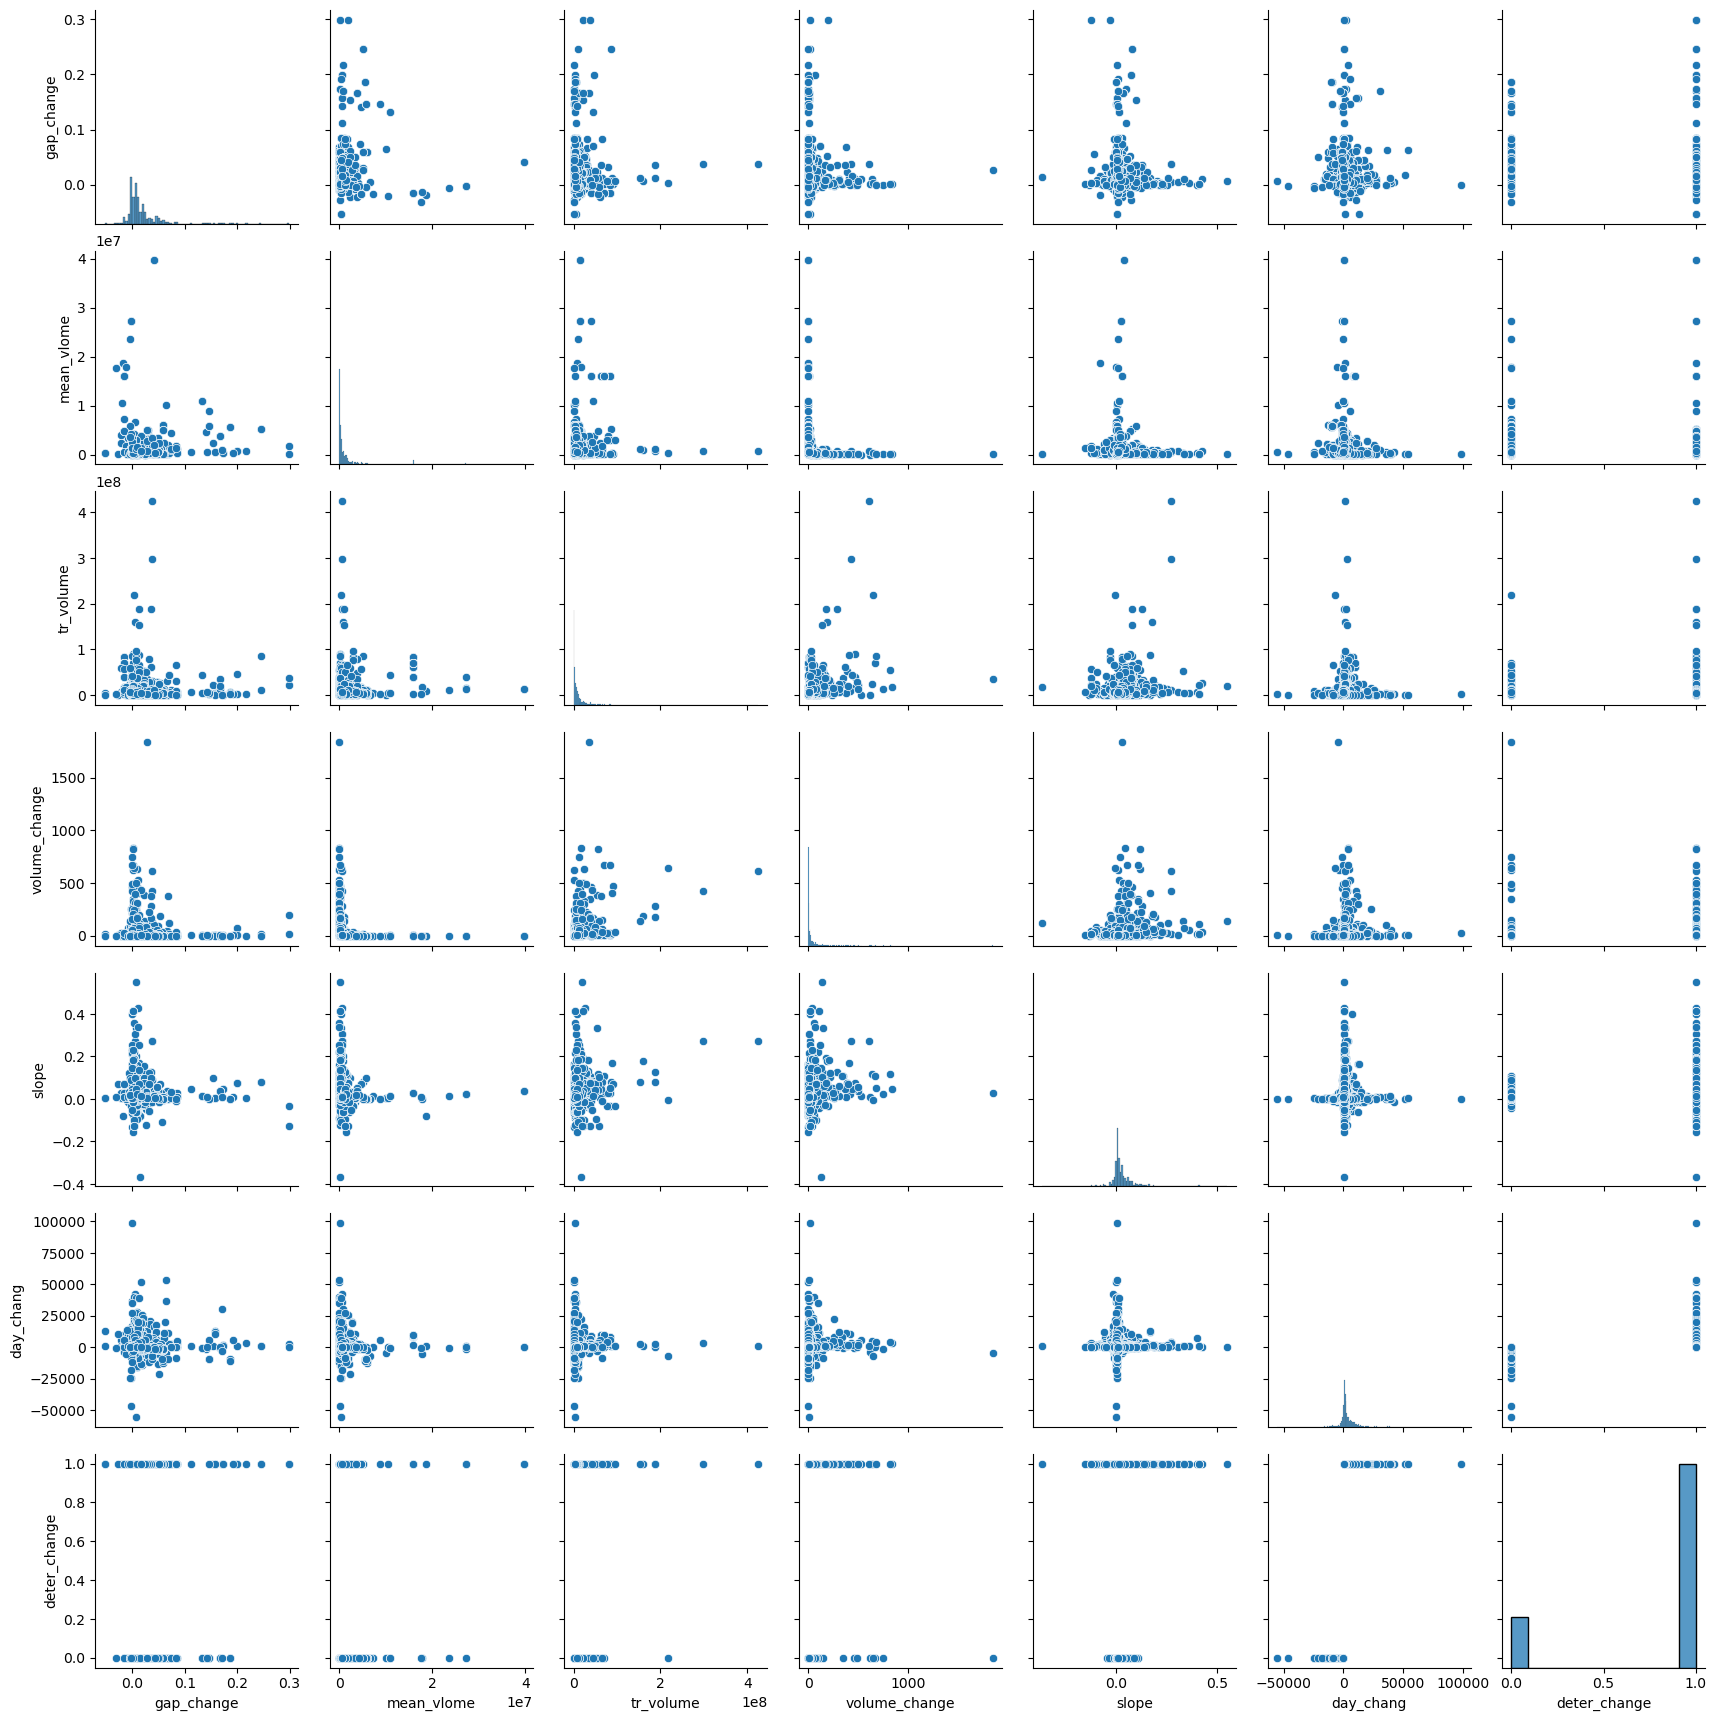

In [176]:
#산전도 그리기
%matplotlib inline
sns.pairplot(stock_data)

In [143]:
parameter = stock2.iloc[:,16:26]
parameter = parameter.T
for i in range(len(parameter.columns)):
    name = f'price{i}' 
    parameter = parameter.rename(columns={i:name})

parameter = parameter.reset_index().drop(columns=['index'])
parameter = parameter.reset_index()

data2=pd.DataFrame()
for i in range(0,982):
    model = sm.OLS.from_formula(f'index ~ price{i}', parameter).fit()
    slope = model.params[f'price{i}']
    temp = pd.DataFrame({'slope': slope} ,index =[i])
    data2 = pd.concat([data2,temp])

stock2['slope'] = data2

In [185]:
inf_index = stock_data.query('volume_change>100000').index
stock_data = stock_data.drop(index = inf_index)

In [202]:
Y = stock_data['deter_change']
X = stock_data[['slope','gap_change']]

In [203]:
X = sm.add_constant(X)
model = sm.Logit(Y,X)
results = model.fit()

Optimization terminated successfully.
         Current function value: 0.482647
         Iterations 6


In [204]:
print( results.summary())

                           Logit Regression Results                           
Dep. Variable:           deter_change   No. Observations:                  963
Model:                          Logit   Df Residuals:                      960
Method:                           MLE   Df Model:                            2
Date:                Sun, 19 Feb 2023   Pseudo R-squ.:                 0.03101
Time:                        18:54:15   Log-Likelihood:                -464.79
converged:                       True   LL-Null:                       -479.66
Covariance Type:            nonrobust   LLR p-value:                 3.475e-07
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4571      0.100     14.580      0.000       1.261       1.653
slope          4.9532      1.642      3.016      0.003       1.735       8.172
gap_change    -8.2891      1.985     -4.176      0.0